# 라이브러리

In [1]:
import pandas as pd
import numpy as np
import os
# torch.manual_seed(1234)
from evaluate_metrics import compute_eer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# score file

In [9]:
# 1. 점수 파일 읽기
score_file_path = '/home/woonj/grad-cam/experiment_results/ps_eval_score.txt'
scores = []
with open(score_file_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        filepath = parts[0]
        spoof_score = float(parts[1])  # 가짜 점수
        bonafide_score = float(parts[2])  # 진짜 점수
        # 'utt' 형식으로 변환
        utt = filepath.split('/')[-1]  # 파일 경로에서 파일 이름만 추출
        scores.append((utt, spoof_score, bonafide_score))

# DataFrame으로 변환
scores_df = pd.DataFrame(scores, columns=['utt', 'spoof_score', 'bonafide_score'])

# 2. 레이블 파일 읽기
# label_file_path = '/home/woonj/analyze_missclassification/analyze_music/get_score_preprocess/inwild_bona_protocol.txt'
label_file_path = '/home/woonj/grad-cam/ps/ps_protocol.txt'
labels = []
with open(label_file_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        utt = parts[0].replace('eval/', '')  # 'eval/' 부분 제거
        subset = parts[1]
        label = parts[2].replace('abrupt', 'spoof')  # 'abrupt' 레이블을 'spoof'로 변경
        labels.append((utt, subset, label))

labels_df = pd.DataFrame(labels, columns=['utt', 'subset', 'label'])

# 3. 레이블에 따라 점수 데이터프레임 병합 후 저장
merged_df = scores_df.merge(labels_df, on='utt')  # 'utt'를 기준으로 병합



IndexError: index 0 is out of bounds for axis 0 with size 0

In [17]:
merged_df.columns = ['utt', 'spoof', 'bonafide', 'subset', 'label']
merged_df.head()
merged_df.to_csv('merged_ps_eval.csv', index=False)

In [18]:
# 4. 진짜 점수와 가짜 점수 배열 생성
spoof_scores = merged_df[merged_df['label'] == 'spoof']['bonafide']
bonafide_scores = merged_df[merged_df['label'] == 'bonafide']['bonafide']

# 5. EER 계산
eer, eer_threshold = compute_eer(bonafide_scores, spoof_scores)
print(f"EER: {eer:.4f}")
print(f"EER Threshold: {eer_threshold:.4f}")

EER: 0.3763
EER Threshold: -6.9030


# 시각화

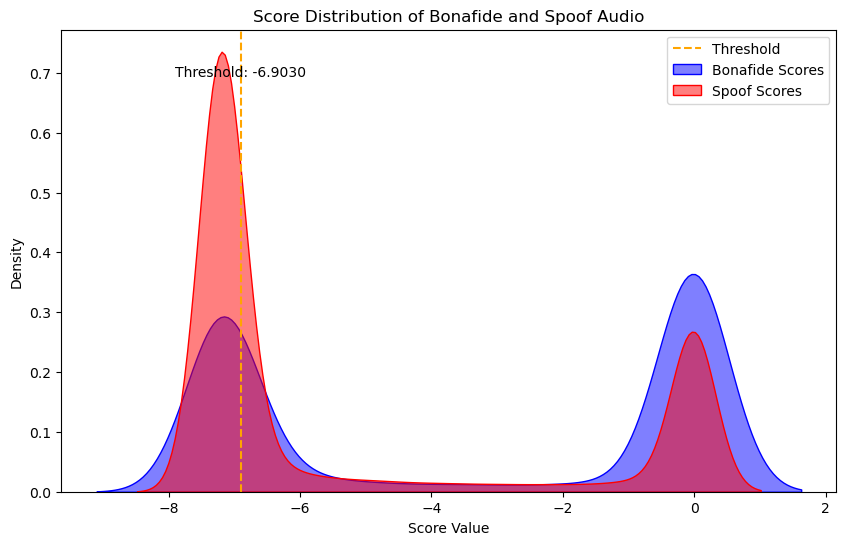

In [19]:
# 6. KDE 플롯 시각화
plt.figure(figsize=(10, 6))
sns.kdeplot(bonafide_scores, label='Bonafide Scores', color='blue', fill=True, alpha=0.5)
sns.kdeplot(spoof_scores, label='Spoof Scores', color='red', fill=True, alpha=0.5)

# 7. 임계값 수직선 추가
plt.axvline(x=eer_threshold, color='orange', linestyle='--', label='Threshold')
plt.text(eer_threshold, plt.ylim()[1]*0.9, f'Threshold: {eer_threshold:.4f}', color='black', fontsize=10, ha='center')
# 8. 플롯 제목 및 레이블 설정
plt.title('Score Distribution of Bonafide and Spoof Audio')
plt.xlabel('Score Value')
plt.ylabel('Density')
plt.legend()
plt.show()

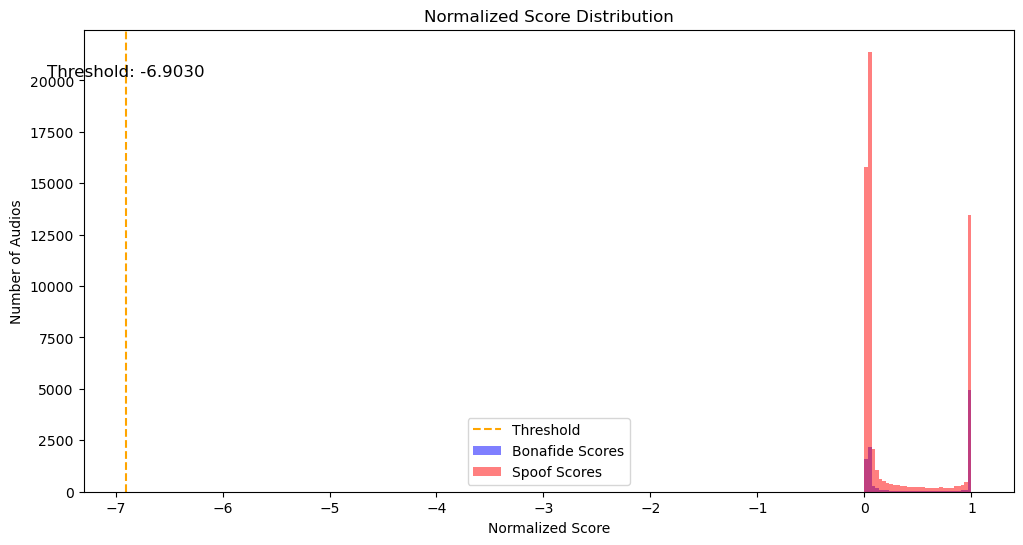

In [21]:
# Min-Max 정규화 함수
def min_max_normalize(scores):
    return (scores - np.min(scores)) / (np.max(scores) - np.min(scores))

# 스코어 정규화
normalized_bonafide = min_max_normalize(bonafide_scores)
normalized_spoof = min_max_normalize(spoof_scores)

# 히스토그램 그리기
plt.figure(figsize=(12, 6))
plt.hist(normalized_bonafide, bins=30, alpha=0.5, label='Bonafide Scores', color='blue')
plt.hist(normalized_spoof, bins=30, alpha=0.5, label='Spoof Scores', color='red')
plt.axvline(x=eer_threshold, color='orange', linestyle='--', label='Threshold')
plt.text(eer_threshold, plt.ylim()[1]*0.9, f'Threshold: {eer_threshold:.4f}', color='black', fontsize=12, ha='center')
plt.title('Normalized Score Distribution')
plt.xlabel('Normalized Score')
plt.ylabel('Number of Audios')
plt.legend()
plt.show()